In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_sovanta = pd.read_csv("eval-llm-judge-sovanta.csv")
df_wikieval = pd.read_csv("eval-llm-judge-wikieval.csv")

# 1. Alignment of LLM-Judges with human judgement
sovanta

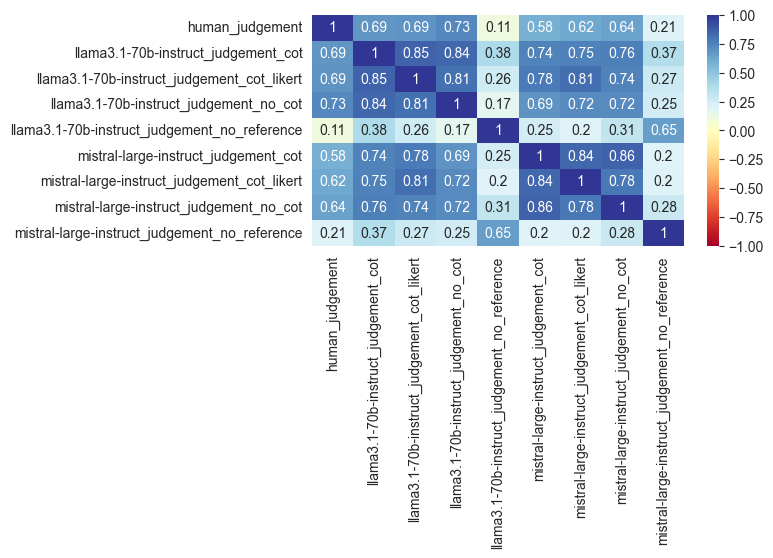

In [2]:
plt.figure(figsize=(6, 3))
ax1 = plt.gca()
sov_cols = sorted([col for col in df_sovanta.columns if "judgement" in col and "v2" not in col])
labels = [j.split("--")[-1] for j in sov_cols]
corr_sov = df_sovanta[sov_cols].corr()
sns.heatmap(
    corr_sov,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax1,
)
plt.show()

Wikieval

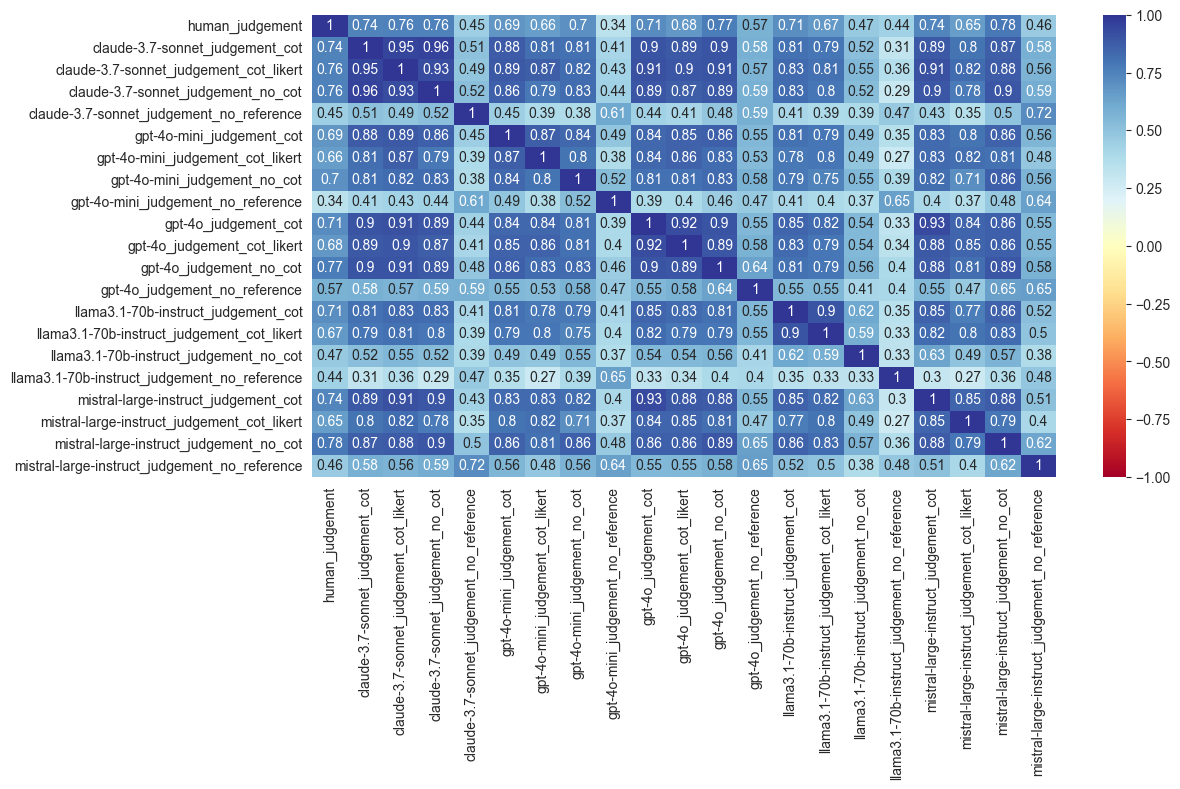

In [3]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
sov_cols = ["human_judgement"] + sorted(
    [col for col in df_wikieval.columns if "judgement" in col and "v2" not in col and "human" not in col]
)
labels = [j.split("--")[-1] for j in sov_cols]
corr_sov = df_wikieval[sov_cols].corr()
sns.heatmap(
    corr_sov,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax1,
)
plt.show()

--> for sovanta, Llama3.1 without CoT has the highest correlation at 0.73

--> for Wikieval, Mistral-Large without CoT has the highest correlation at 0.78

## Validation
lets check the results and find possible issues with the human labels
### 1. Wikieval

In [15]:
sov_cols = sorted([col for col in df_sovanta.columns if "judgement" in col and "v2" not in col])
wikieval_cols = sorted([col for col in df_wikieval.columns if "judgement" in col and "v2" not in col])

corr_sov = df_sovanta[sov_cols].corr()
corr_wikieval = df_wikieval[wikieval_cols].corr()
useful_judges = list(corr_wikieval[corr_wikieval["human_judgement"] > 0.7].index)
useful_judges.remove("human_judgement")
diff_cols = []
for judge in useful_judges:
    df_wikieval[f"{judge}_diff"] = df_wikieval[judge] - df_wikieval["human_judgement"]
    diff_cols.append(f"{judge}_diff")

mask = (np.abs(df_wikieval[diff_cols]) >= 0.5).any(axis=1)
rows_with_large_diff = df_wikieval[mask]

for i, row in rows_with_large_diff.iterrows():
    print(f"\n--- Row {i + 1} ---")
    print(f"Prompt:      {row['prompt']}")
    print(f"Gold Answer: {row['gold_answer']}")
    print(f"Answer:      {row['answer']}")
    print(f"Human Judgement: {row['human_judgement']}")
    print(f"Average LLM Judgement: {row[useful_judges].mean()}")


--- Row 1 ---
Prompt:      How does the height and thrust of the Starship rocket compare to other rockets?
Gold Answer: The Starship rocket has a height of 120 meters (394 feet), making it the largest and most powerful rocket ever flown. It surpasses the thrust of NASA's Space Launch System, Saturn V, and the Soviet N1, which previously held the record. The Starship rocket has a liftoff mass of 5,000 metric tons (11,000,000 pounds) and is powered by Raptor rocket engines, which burn liquid methane and liquid oxygen. It operates in a full-flow staged combustion power cycle. The rocket is designed to be fully reusable, with both the first-stage Super Heavy booster and the second-stage spacecraft, also named Starship, performing controlled landings. The Starship rocket has a payload capacity of 150 tonnes (330,000 lb) to low Earth orbit in a fully reusable configuration and 250 t (550,000 lb) when expended. It is also designed to enable transit to higher energy destinations such as geosy

--> some errors with human judgement were corrected. Biggest problem: too much information in gold answers

### 2. sovanta

In [ ]:
useful_judges = list(corr_sov[corr_sov["human_judgement"] > 0.65].index)
useful_judges.remove("human_judgement")
diff_cols = []
for judge in useful_judges:
    df_sovanta[f"{judge}_diff"] = df_sovanta[judge] - df_sovanta["human_judgement"]
    diff_cols.append(f"{judge}_diff")

mask = (np.abs(df_sovanta[diff_cols]) >= 0.5).any(axis=1)
rows_with_large_diff = df_sovanta[mask]

for i, row in rows_with_large_diff.iterrows():
    print(f"\n--- Row {i + 1} ---")
    print(f"Prompt:      {row['prompt']}")
    print(f"Gold Answer: {row['gold_answer']}")
    print(f"\n--Answer:      {row['answer']}")
    print(f"Human Judgement: {row['human_judgement']}")
    print(f"Average LLM Judgement: {row[useful_judges].mean()}")

--> some errors with human judgement were corrected

# 2. Alignment of legacy metrics with human judgement

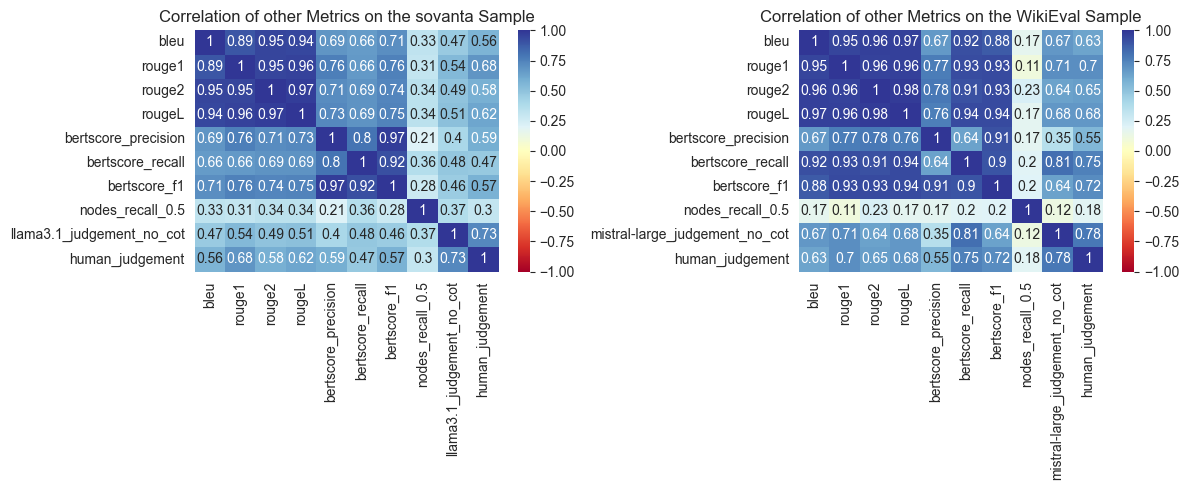

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cols = [
    "bleu",
    "rouge1",
    "rouge2",
    "rougeL",
    "bertscore_precision",
    "bertscore_recall",
    "bertscore_f1",
    "nodes_recall_0.5",
]
sovanta_cols = cols + [
    "meta--llama3.1-70b-instruct_judgement_no_cot",
    "human_judgement",
]
wikieval_cols = cols + [
    "mistralai--mistral-large-instruct_judgement_no_cot",
    "human_judgement",
]
s_labels = cols + ["llama3.1_judgement_no_cot", "human_judgement"]
w_labels = cols + ["mistral-large_judgement_no_cot", "human_judgement"]

corr_sov = df_sovanta[sovanta_cols].corr()
corr_wikieval = df_wikieval[wikieval_cols].corr()

sns.heatmap(
    corr_sov,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=s_labels,
    yticklabels=s_labels,
    ax=ax1,
)
ax1.set_title("Correlation of other Metrics on the sovanta Sample")

sns.heatmap(
    corr_wikieval,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=w_labels,
    yticklabels=w_labels,
    ax=ax2,
)
ax2.set_title("Correlation of other Metrics on the WikiEval Sample")

plt.tight_layout()
plt.show()

In [17]:
df_sovanta["diff"] = df_sovanta["nodes_recall_0.5"] - df_sovanta["human_judgement"]
a = df_sovanta[df_sovanta["diff"] > 0]
print(a.shape)
b = df_sovanta[df_sovanta["diff"] < 0]
print(b.shape)
c = df_sovanta[df_sovanta["diff"] == 0]
print(c.shape)

(42, 44)
(25, 44)
(35, 44)


--> Interesting observation: ROUGE-1 is almost as aligned with human feedback than LLM Judge

--> Overall: The LLM Judges have the highest correlation with human judgement

# 3. Alignment of no-reference metrics with human judgement

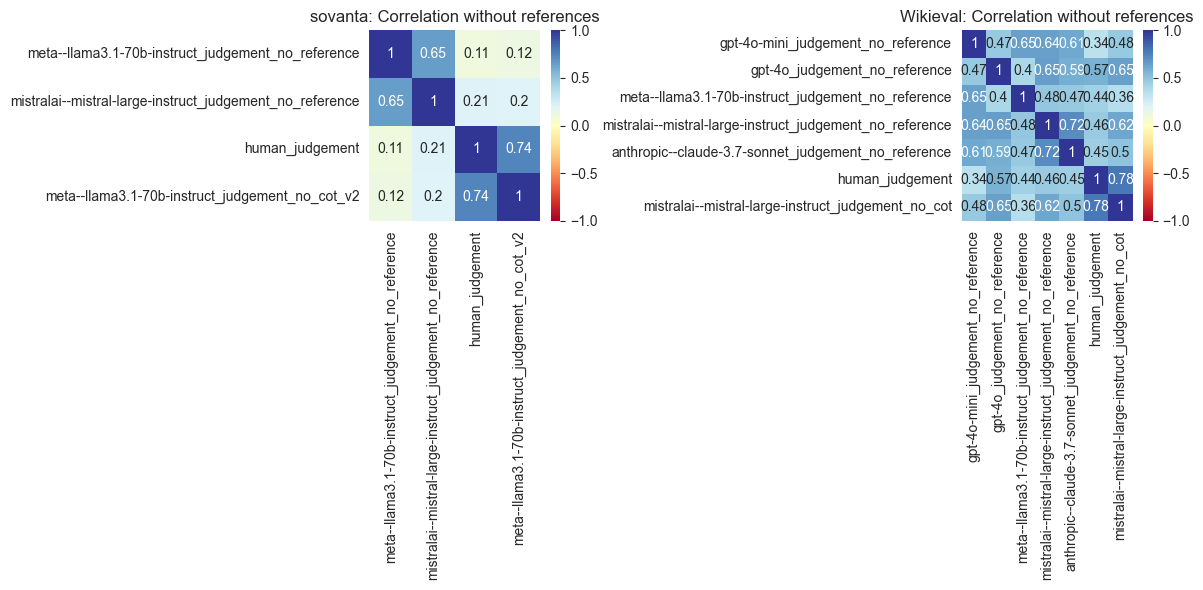

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sovanta_cols = [col for col in df_sovanta.columns if "no_reference" in col] + [
    "human_judgement",
    "meta--llama3.1-70b-instruct_judgement_no_cot_v2",
]
wikieval_cols = [col for col in df_wikieval.columns if "no_reference" in col] + [
    "human_judgement",
    "mistralai--mistral-large-instruct_judgement_no_cot",
]

corr_sov = df_sovanta[sovanta_cols].corr()
corr_wikieval = df_wikieval[wikieval_cols].corr()

sns.heatmap(
    corr_sov,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=sovanta_cols,
    yticklabels=sovanta_cols,
    ax=ax1,
)
ax1.set_title("sovanta: Correlation without references")

sns.heatmap(
    corr_wikieval,
    annot=True,
    cmap="RdYlBu",
    vmin=-1,
    vmax=1,
    xticklabels=wikieval_cols,
    yticklabels=wikieval_cols,
    ax=ax2,
)
ax2.set_title("Wikieval: Correlation without references")

plt.tight_layout()
plt.show()